In [221]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
import urllib
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# if running on Colab, uncomment and run this line below too:
# !pip install mapclassify

In [3]:
output_dir = "output/"
os.makedirs(output_dir, exist_ok=True)

In [206]:
# Functions

def datasette_query(db, sql_string):
    params = urllib.parse.urlencode({
        "sql": sql_string,
        "_size": "max"
        })
    url = f"https://datasette.planning.data.gov.uk/{db}.csv?{params}"
    df = pd.read_csv(url)
    return df

def get_pdp_dataset(dataset, geometry_field = "geometry", crs_out=4326, underscore_cols=True):

    df = pd.read_csv(f"https://files.planning.data.gov.uk/dataset/{dataset}.csv", dtype = "str")
    df.columns = [x.replace("-", "_") for x in df.columns]

    df_valid_geom = df[df[geometry_field].notnull()].copy()

    # load geometry and create GDF
    df_valid_geom[geometry_field] = df_valid_geom[geometry_field].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df_valid_geom, geometry = geometry_field)

    # Transform to ESPG:27700 for more interpretable area units
    gdf.set_crs(epsg=4326, inplace=True)
    gdf.to_crs(epsg=crs_out, inplace=True)

    return gdf


## Data in

In [207]:
# get org lookup
org_df = datasette_query(
    "digital-land",
    """
        select entity as organisation_entity, name as org_name, organisation, dataset as org_type, end_date, 
        local_planning_authority as LPACD, local_authority_district,
        case when local_planning_authority != "" or organisation in ("local-authority:NDO", "local-authority:PUR") then 1 else 0 end as lpa_flag
        from organisation
        where name != "Waveney District Council"
    """
)

print(len(org_df))
org_df[["lpa_flag", "organisation_entity"]] = org_df[["lpa_flag", "organisation_entity"]].astype(int)

454


In [227]:
ca_latest_res = datasette_query(
    "performance",
    """
    select organisation, organisation_name, dataset, max(resource_start_date) as latest_resource_start_date
    from reporting_historic_endpoints
    where 1=1
        and dataset = "conservation-area"
        and latest_status = 200
    group by organisation, organisation_name, dataset
    """
)

print(len(ca_latest_res))
ca_latest_res = ca_latest_res.merge(
    org_df[["organisation", "organisation_entity"]],
    how = "left",
    on = "organisation"
)
ca_latest_res["latest_resource_start_date"] = pd.to_datetime(ca_latest_res["latest_resource_start_date"])
print(len(ca_latest_res))
ca_latest_res.head()

87
87


,organisation,organisation_name,dataset,latest_resource_start_date,organisation_entity
0,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",conservation-area,2024-10-25,600001
1,government-organisation:D4,"Ministry of Housing, Communities and Local Gov...",conservation-area,2021-05-08,12
2,government-organisation:PB1164,Historic England,conservation-area,2023-07-22,16
3,local-authority:BAB,Babergh District Council,conservation-area,2021-03-31,33
4,local-authority:BAR,Barrow-in-Furness Borough Council,conservation-area,2020-09-06,37


In [199]:
ca_gdf = get_pdp_dataset("conservation-area", "point")
ca_gdf[["organisation_entity"]] = ca_gdf[["organisation_entity"]].astype(int)

print(len(ca_gdf))

ca_gdf = ca_gdf.merge(
    org_df[["organisation_entity", "org_name", "lpa_flag"]],
    how = "left",
    on = "organisation_entity"
)

print(len(ca_gdf))

8611
8611


In [200]:
# LPA boundaries from PDP site
lpa_gdf = get_pdp_dataset("local-planning-authority", "geometry")

# rename for easier joining
lpa_gdf.rename(columns={
        'name':'lpa_name',
        'reference':'LPACD'}, 
    inplace=True)

print(len(lpa_gdf))

# join on LAD org names and populated end date
lpa_gdf = lpa_gdf[["dataset", "entity", "geometry", "lpa_name", "LPACD"]].merge(
    org_df[["LPACD", "end_date"]],
    how = "left",
    on = "LPACD"
)

lpa_live_gdf = lpa_gdf[lpa_gdf["end_date"].isnull()].copy()

print(len(lpa_gdf))
lpa_gdf.head()

326
326


,dataset,entity,geometry,lpa_name,LPACD,end_date
0,local-planning-authority,626001,"MULTIPOLYGON (((-1.55941 54.88204, -1.56062 54...",County Durham LPA,E60000001,NaN
1,local-planning-authority,626002,"MULTIPOLYGON (((-1.43836 54.59508, -1.43859 54...",Darlington LPA,E60000002,NaN
2,local-planning-authority,626003,"MULTIPOLYGON (((-1.23963 54.72387, -1.24252 54...",Hartlepool LPA,E60000003,NaN
3,local-planning-authority,626004,"MULTIPOLYGON (((-1.19860 54.58287, -1.19917 54...",Middlesbrough LPA,E60000004,NaN
4,local-planning-authority,626005,"MULTIPOLYGON (((-1.54048 55.33793, -1.54057 55...",Northumberland LPA,E60000005,NaN


## Analysis

### Spatial joining

In [201]:
# join LPAs to all conservation areas, then join on the names of supplying organisations for matching conservation areas
lpa_ca_join = gpd.sjoin(
    lpa_live_gdf[["LPACD", "lpa_name", "geometry"]],
    ca_gdf[["entity", "organisation_entity", "org_name", "lpa_flag", "point"]],
    how = "left",
    predicate = "intersects"
)

print(len(lpa_ca_join))
lpa_ca_join.head()


8647


,LPACD,lpa_name,geometry,index_right,entity,organisation_entity,org_name,lpa_flag
0,E60000001,County Durham LPA,"MULTIPOLYGON (((-1.55941 54.88204, -1.56062 54...",4466.0,44004822,16.0,Historic England,0.0
0,E60000001,County Durham LPA,"MULTIPOLYGON (((-1.55941 54.88204, -1.56062 54...",6039.0,44006439,16.0,Historic England,0.0
0,E60000001,County Durham LPA,"MULTIPOLYGON (((-1.55941 54.88204, -1.56062 54...",4467.0,44004823,16.0,Historic England,0.0
0,E60000001,County Durham LPA,"MULTIPOLYGON (((-1.55941 54.88204, -1.56062 54...",5161.0,44005530,16.0,Historic England,0.0
0,E60000001,County Durham LPA,"MULTIPOLYGON (((-1.55941 54.88204, -1.56062 54...",5609.0,44006004,16.0,Historic England,0.0


In [248]:
# set HE org_ent to 0 for group by so we can get LA org ent when it exists in an LPA
lpa_ca_join["org_ent_pre_rank"] = np.where(lpa_ca_join["organisation_entity"] == 16, 0, lpa_ca_join["organisation_entity"])

lpa_prov_map = lpa_ca_join.groupby(["LPACD", "lpa_name", "geometry"], as_index=False).agg(
    prov_rank_max = ("lpa_flag", "max"),
    org_ent_max = ("org_ent_pre_rank", "max")
)

# set HE org_ent back to 16 in grouped table
lpa_prov_map["organisation_entity"] = np.where(lpa_prov_map["org_ent_max"] == 0, 16, lpa_prov_map["org_ent_max"])


rank_quality = dict(
    {
        1 : "1_authoritative",
        0 : "2_alternative",
        np.nan : "3_none"
    })


lpa_prov_map["prov_quality"] = lpa_prov_map["prov_rank_max"].map(rank_quality)

lpa_prov_map = lpa_prov_map.merge(
    ca_latest_res[["organisation_entity", "organisation", "latest_resource_start_date"]],
    how = "left",
    on = "organisation_entity"
)

lpa_prov_map = gpd.GeoDataFrame(lpa_prov_map, geometry = "geometry")
# simplify to make mapping quicker
lpa_prov_map["geometry"] = lpa_prov_map["geometry"].simplify(0.001)

lpa_prov_map.head()

,LPACD,lpa_name,geometry,prov_rank_max,org_ent_max,organisation_entity,prov_quality,organisation,latest_resource_start_date
0,E60000001,County Durham LPA,"POLYGON ((-1.55941 54.88204, -1.57991 54.87777...",0.0,0.0,16.0,2_alternative,government-organisation:PB1164,2023-07-22
1,E60000002,Darlington LPA,"POLYGON ((-1.43836 54.59508, -1.44340 54.59062...",0.0,0.0,16.0,2_alternative,government-organisation:PB1164,2023-07-22
2,E60000003,Hartlepool LPA,"POLYGON ((-1.23963 54.72387, -1.24402 54.72158...",0.0,0.0,16.0,2_alternative,government-organisation:PB1164,2023-07-22
3,E60000004,Middlesbrough LPA,"POLYGON ((-1.19860 54.58287, -1.21100 54.58114...",0.0,0.0,16.0,2_alternative,government-organisation:PB1164,2023-07-22
4,E60000005,Northumberland LPA,"MULTIPOLYGON (((-1.54048 55.33793, -1.54228 55...",0.0,0.0,16.0,2_alternative,government-organisation:PB1164,2023-07-22


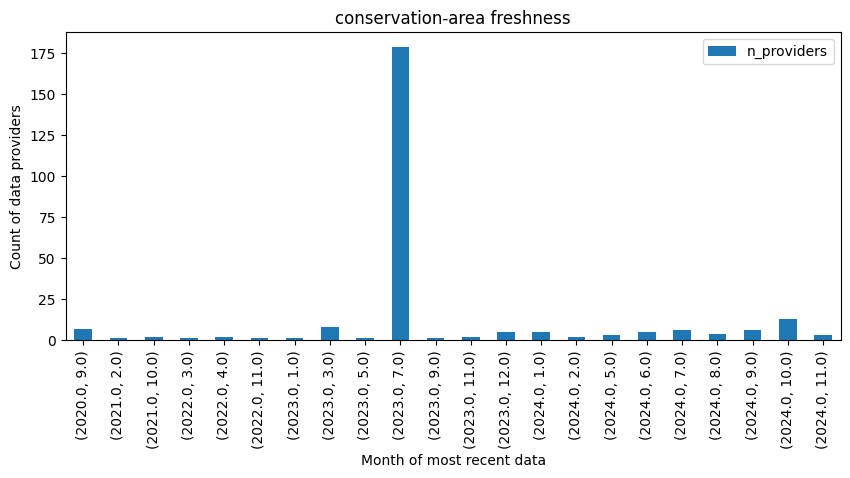

In [263]:
supply_count = lpa_prov_map.groupby(
        [lpa_prov_map["latest_resource_start_date"].dt.year, 
        lpa_prov_map["latest_resource_start_date"].dt.month]
     ).agg(
        n_providers = ("organisation", "count")    
     )

fig, ax = plt.subplots(figsize=(10, 4))

supply_count.plot(
    ax = ax,
    y = "n_providers", 
    kind="bar")
ax.set_title('conservation-area freshness')
ax.set_xlabel("Month of most recent data")
ax.set_ylabel("Count of data providers")
plt.show()

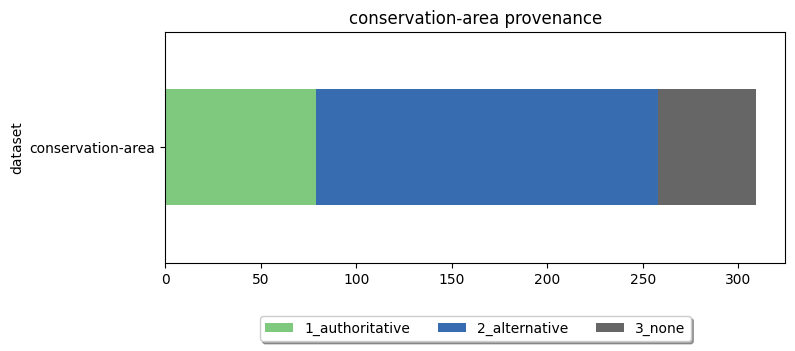

In [204]:
# count by provenance and pivot for chart
qual_count = lpa_prov_map.groupby(
        ["prov_quality"],
        as_index = False
    ).agg(
        n_providers = ("lpa_name", "count")
)
qual_count["dataset"] = "conservation-area"
qual_count = qual_count.pivot(columns = "prov_quality", values = "n_providers", index = "dataset")

# CHART
fig, ax = plt.subplots(figsize=(8, 3))
qual_count.plot.barh(
    ax = ax,
    stacked = True,
    cmap = "Accent",)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,
                 box.width, box.height])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

ax.set_title('conservation-area provenance')
plt.show()

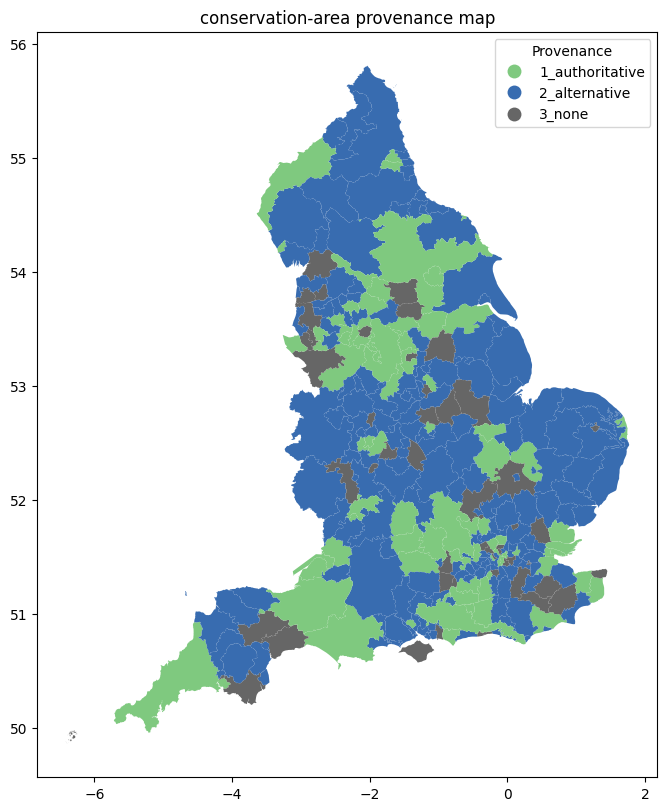

In [264]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))
lpa_prov_map.plot(
    ax = ax,
    column = "prov_quality",
    # color = lpa_prov_map["prov_colour"],
    legend = True,
    legend_kwds={"title": "Provenance"},
    cmap = "Accent",   
)

ax.set_title('conservation-area provenance map')
plt.show()

In [ ]:
lpa_prov_map.explore(
    column = "prov_quality"
)